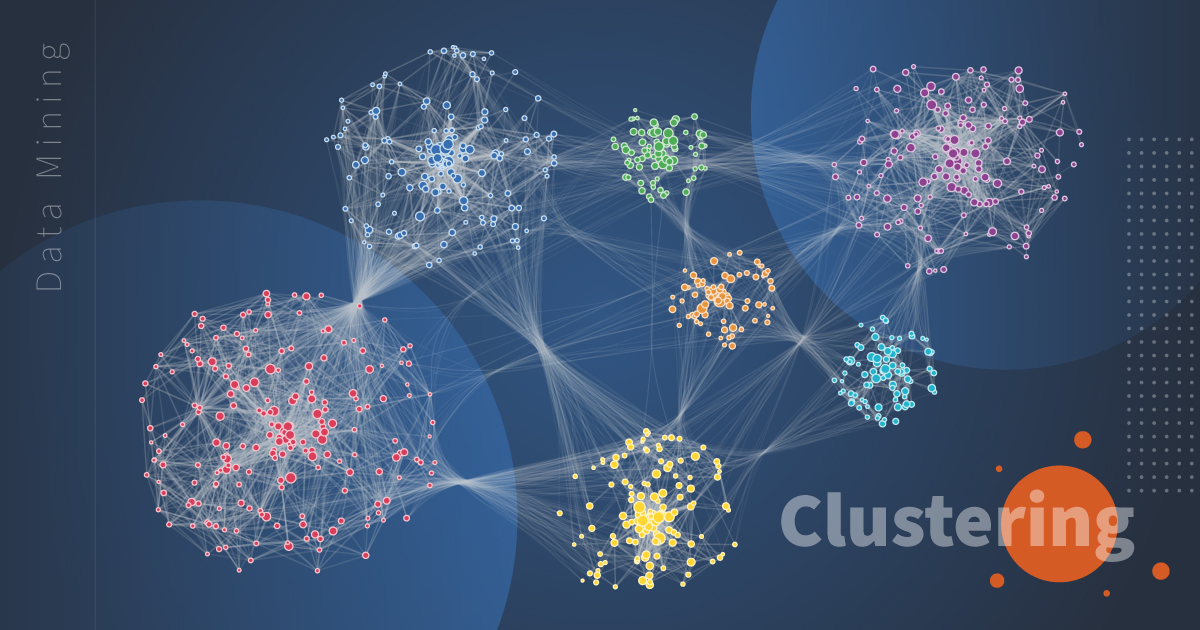

### Загрузка и начальная обработка данных

Сначала выполним импорт всех необходимых библиотек.





In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans

Откроем данные и проверим, что все загрузилось корректно.

In [ ]:
raw_data = pd.read_csv('/content/sales.csv', sep = ';')
raw_data.rename(columns = {'IdClient' : 'ID', 'InsertDate' : 'from_today', 'sumTotal' : 'total'}, inplace = True)

raw_data.info()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          10570 non-null  object
 1   from_today  10570 non-null  object
 2   total       10570 non-null  object
dtypes: object(3)
memory usage: 247.9+ KB


,ID,from_today,total
0,446B08B5-04A8-4404-8F21-A462A7C67E66,2013-03-02 18:22:00.897,"1619,00"
1,6C1B2E2A-BC8C-4657-B698-191642FE5328,2013-03-03 12:27:10.897,"546,00"
2,9546F649-D322-48D1-8B97-21D17C3967DF,2013-03-03 12:34:55.877,"218,00"
3,2CE2C5AC-FC6B-4ECA-91AC-6498008EAC0E,2013-03-03 13:38:09.263,"977,00"
4,7C3F9169-EDBC-4388-8407-F523954B253B,2013-03-03 14:31:21.327,"270,00"


Как мы видим, пропуски в данных отсутствуют.

Переведем столбцы в более удобный формат. 

In [ ]:
raw_data['total'] = raw_data['total'].apply(lambda x: float(x.replace(',', '.')))

raw_data.head()

,ID,from_today,total
0,446B08B5-04A8-4404-8F21-A462A7C67E66,2013-03-02 18:22:00.897,1619.0
1,6C1B2E2A-BC8C-4657-B698-191642FE5328,2013-03-03 12:27:10.897,546.0
2,9546F649-D322-48D1-8B97-21D17C3967DF,2013-03-03 12:34:55.877,218.0
3,2CE2C5AC-FC6B-4ECA-91AC-6498008EAC0E,2013-03-03 13:38:09.263,977.0
4,7C3F9169-EDBC-4388-8407-F523954B253B,2013-03-03 14:31:21.327,270.0


### Подготовка данных


Создадим еще один датафрейм, который будет содержать сжатую информацию о клиентах.

In [ ]:
column_size = len(set(raw_data['ID']))
ID_set = list(set(raw_data['ID']))

data = pd.DataFrame({'ID': [ID_set[i] for i in range(len(ID_set))],
                  'recency': [0] * column_size,
                  'frequency': [0] * column_size,
                  'monetary': [0] * column_size})

Разобьем полученные данные на 5 групп. Каждый покупатель при этом получит идентификатор от 1 до 5 в зависимости от его активности. Тем, кто недавно осуществлял покупку, будет присвоен код R = 5. Те, кто дольше всех не покупал ничего, получат R = 1.

Сначала рассчитаем время, прошедшее с каждой покупки клиента.

In [ ]:
import datetime

def delta_date(d):
  d = list(map(int, d[:10].split('-')))
  d = datetime.date(d[0], d[1], d[2])

  return int(str(datetime.date.today() - d).split()[0])

raw_data['from_today'] = raw_data['from_today'].apply(delta_date)

Затем найдем последние покупки людей и присвоим им соответствующий идентификатор. 

In [ ]:
raw_data.head()

,ID,from_today,total
0,446B08B5-04A8-4404-8F21-A462A7C67E66,3494,1619.0
1,6C1B2E2A-BC8C-4657-B698-191642FE5328,3493,546.0
2,9546F649-D322-48D1-8B97-21D17C3967DF,3493,218.0
3,2CE2C5AC-FC6B-4ECA-91AC-6498008EAC0E,3493,977.0
4,7C3F9169-EDBC-4388-8407-F523954B253B,3493,270.0


In [ ]:
def encode(raw_data, data, data_index, f):
  k = 5
  recent = pd.Series([0] * len(ID_set), index = ID_set)

  for i in ID_set:
    recent[i] = f(raw_data, i)

  bin = recent.value_counts(bins = k)
  bin_intervals = list(reversed(sorted(bin.keys())))

  for i in range(column_size):
    for j in range(k):
      if recent[ID_set[i]] in bin_intervals[j]:
        data[data_index][i] = j + 1

In [ ]:
encode(raw_data, data, 'recency', lambda raw_data, i: min(raw_data[raw_data['ID'] == i]['from_today']))

data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,recency,frequency,monetary
0,A9731C11-478F-4CD0-AE3F-9BCB0EB33F50,2,0,0
1,D34F9721-7B3C-424E-B35B-4708FA9547AF,3,0,0
2,BF23F622-C7FD-4D4F-86EC-C2633A3CB448,1,0,0
3,E6949CD6-411A-4880-95A9-6369B2949E85,2,0,0
4,3F28D98B-2754-4D7C-AC76-5F10CD41CDD8,2,0,0


Теперь разобъем данные на 5 групп по количеству покупок. Клиентам, совершившим наибольшее число покупок, будет присвоен код F = 5, наименее активные покупатели получат F = 1.

In [ ]:
encode(raw_data, data, 'frequency', lambda raw_data, i: len(raw_data[raw_data['ID'] == i]))

data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,recency,frequency,monetary
0,A9731C11-478F-4CD0-AE3F-9BCB0EB33F50,2,5,0
1,D34F9721-7B3C-424E-B35B-4708FA9547AF,3,5,0
2,BF23F622-C7FD-4D4F-86EC-C2633A3CB448,1,5,0
3,E6949CD6-411A-4880-95A9-6369B2949E85,2,5,0
4,3F28D98B-2754-4D7C-AC76-5F10CD41CDD8,2,5,0


Также проведем классификацию по параметру monetary. Клиентам, потратившим наибольшие суммы, будет присвоен код М = 5, а потратившим наименьшие суммы – М = 1.

In [ ]:
def monetary_f(raw_data, i):
  temp_data = raw_data[raw_data['ID'] == i]['total']
  summ = 0

  for i in temp_data.keys():
    summ += temp_data[i]

  return summ / len(temp_data)

encode(raw_data, data, 'monetary', monetary_f)

data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,recency,frequency,monetary
0,A9731C11-478F-4CD0-AE3F-9BCB0EB33F50,2,5,5
1,D34F9721-7B3C-424E-B35B-4708FA9547AF,3,5,4
2,BF23F622-C7FD-4D4F-86EC-C2633A3CB448,1,5,5
3,E6949CD6-411A-4880-95A9-6369B2949E85,2,5,5
4,3F28D98B-2754-4D7C-AC76-5F10CD41CDD8,2,5,5


In [ ]:
res = pd.DataFrame({'ID': data['ID'],
                  'cluster': [0] * column_size})

data = data.drop(['ID'], axis = 1)

data.head()

,recency,frequency,monetary
0,2,5,5
1,3,5,4
2,1,5,5
3,2,5,5
4,2,5,5


### Кластеризация

Проверим получившееся распределение данных.

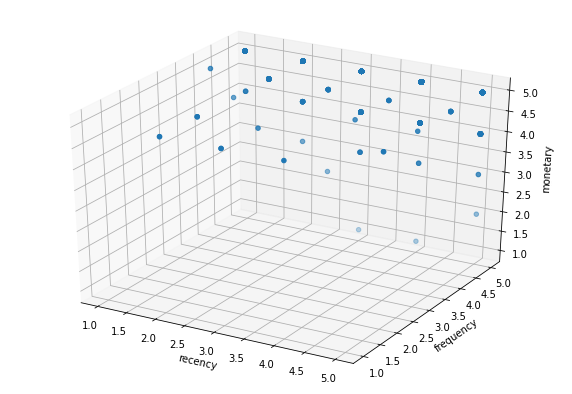

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection = '3d')

ax.scatter3D(data['recency'], data['frequency'], data['monetary'])

ax.set_xlabel('recency')
ax.set_ylabel('frequency')
ax.set_zlabel('monetary')   

plt.show()

Для разделения клиентов воспользуемся наиболее популярным алгоритмом кластеризации - методом k-средних. Это простой, но очень эффективный алгоритм неконтролируемого машинного обучения для кластеризации данных. Основывается он на евклидовом расстоянии между точками данных.

In [ ]:
model = KMeans(n_clusters = 3)
model.fit(data)

res['cluster'] = [i + 1 for i in model.predict(data)]

res.head()

,ID,cluster
0,A9731C11-478F-4CD0-AE3F-9BCB0EB33F50,2
1,D34F9721-7B3C-424E-B35B-4708FA9547AF,3
2,BF23F622-C7FD-4D4F-86EC-C2633A3CB448,2
3,E6949CD6-411A-4880-95A9-6369B2949E85,2
4,3F28D98B-2754-4D7C-AC76-5F10CD41CDD8,2


Посмотрим на то, как алгоритм разделил данные.

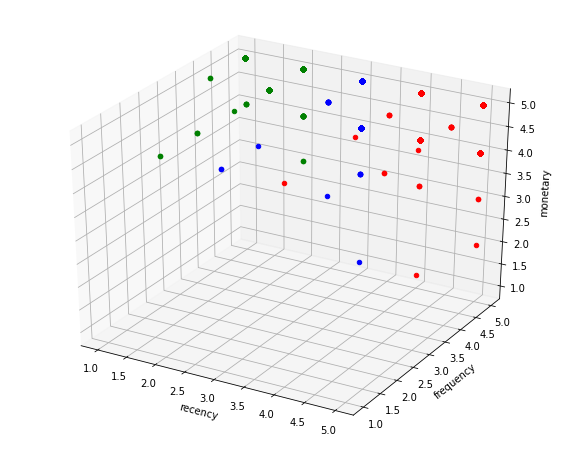

In [ ]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')
colors = ['red', 'green', 'blue']

for i in range(column_size):
    x, y, z = data.iloc[i]['recency'], data.iloc[i]['frequency'], data.iloc[i]['monetary']
    ax.scatter(x, y, z, c = colors[res.iloc[i]['cluster'] - 1])

ax.set_xlabel('recency')
ax.set_ylabel('frequency')
ax.set_zlabel('monetary')

plt.show()

Преобразуем датафрейм с результатами кластеризации в удобный csv формат.

In [ ]:
res.to_csv('clustering_result.csv', index = False)